# Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Loading Data

In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [3]:
test_set = np.load("./results/test_images.npy")
labels = np.load("./results/test_labels.npy")
num_test = len(labels)
results = dict()
models = ["AutoEncoder", "Convolutional0", "Convolutional3", "FullyConnected0", "FullyConnected2", "VAE"]
treatments = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "evens", "odds"]
for model in models:
    for treatment in treatments:
        for i in range(5):
            results[(model, treatment, i)] = np.load("./results/{0}_{1}_{2}.npy".format(model, treatment, i))

## Measuring Performance
We take digit with the highest classifier probability as our prediction and use that to compute accuracy.

In [4]:
performance = dict()
for model in models:
    for treatment in treatments:
        avg = 0
        for i in range(5):
            preds = [np.argmax(softmax(x)) for x in results[(model, treatment, i)]]
            acc = np.sum(preds == labels) / num_test
            avg += acc
        avg /= 5
        performance[(model, treatment)] = avg

## Discritizing Data
We discretize all data to make estimation more tractable.

In [5]:
bins_x = [0.1 * x for x in range(11)]
X = np.vstack([np.digitize(img.reshape(-1), bins_x) for img in test_set])

In [6]:
bins_y = [10 * x for x in range(-5, 5)]
Y_dict = dict()
for model in models:
    for treatment in treatments:
        for i in range(5):
            Y_dict[(model, treatment, i)] = np.digitize(results[(model, treatment, i)], bins_y)

## Estimating Mutual Information
This section can take quite a bit to run.

In [7]:
from sklearn.metrics import mutual_info_score

# https://stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [8]:
med_mut_infos = dict()
max_mut_infos = dict()
mean_mut_infos = dict()
for model in tqdm(models):
    for treatment in tqdm(treatments):
        model_mut_infos = []
        for pixel in range(len(X[0])):
            pixel_vals = X[:, pixel].reshape(-1)
            for i in range(5):
                model_vals = Y_dict[(model, treatment, i)]
                for j in range(10):
                    model_feature_val = model_vals[:, j].reshape(-1)
                    model_mut_infos.append(calc_MI(pixel_vals, model_feature_val, 10))
        med_mut_infos[(model, treatment)] = np.median(model_mut_infos)
        max_mut_infos[(model, treatment)] = np.max(model_mut_infos)
        mean_mut_infos[(model, treatment)] = np.mean(model_mut_infos)

100%|██████████| 6/6 [56:07<00:00, 561.22s/it]


## Determining Correlation
We consider treatments with a single digit removed and half the digits removed seperately.

In [76]:
med_mi_x = []
max_mi_x = []
mean_mi_x = []
acc_y = []
for model in models:
    for treatment in treatments:
        if treatment not in ("evens", "odds"):
            med_mi_x.append(med_mut_infos[(model, treatment)])
            max_mi_x.append(max_mut_infos[(model, treatment)])
            mean_mi_x.append(mean_mut_infos[(model, treatment)])
            acc_y.append(performance[(model, treatment)])

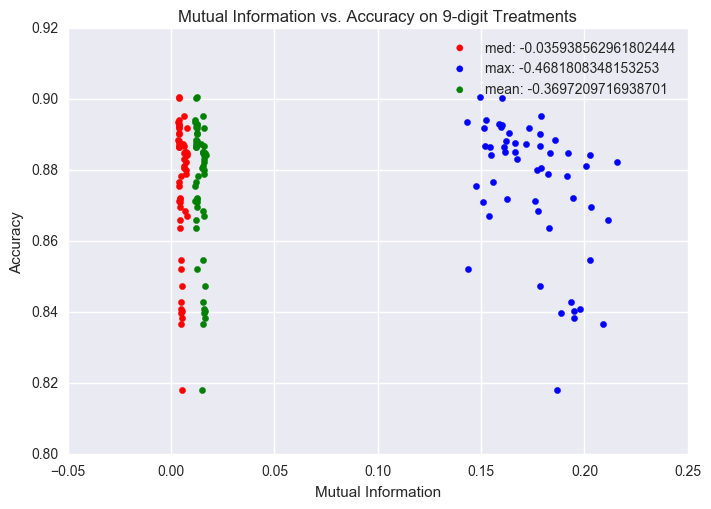

In [77]:
fig, ax = plt.subplots()

ax.scatter(med_mi_x, acc_y, color="red", label="med: {0}".format(np.corrcoef(med_mi_x, acc_y)[0, 1]))
ax.scatter(max_mi_x, acc_y, color="blue", label="max: {0}".format(np.corrcoef(max_mi_x, acc_y)[0, 1]))
ax.scatter(mean_mi_x, acc_y, color="green", label="mean: {0}".format(np.corrcoef(mean_mi_x, acc_y)[0, 1]))
ax.legend()

plt.xlabel("Mutual Information")
plt.ylabel("Accuracy")
plt.title("Mutual Information vs. Accuracy on 9-digit Treatments")
plt.show()

In [78]:
med_mi_x = []
max_mi_x = []
mean_mi_x = []
acc_y = []
for model in models:
    for treatment in ("evens", "odds"):
        med_mi_x.append(med_mut_infos[(model, treatment)])
        max_mi_x.append(max_mut_infos[(model, treatment)])
        mean_mi_x.append(mean_mut_infos[(model, treatment)])
        acc_y.append(performance[(model, treatment)])

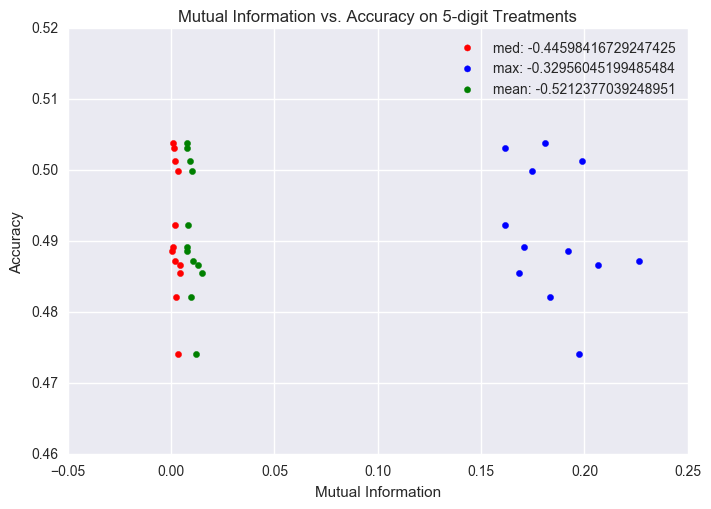

In [79]:
fig, ax = plt.subplots()

ax.scatter(med_mi_x, acc_y, color="red", label="med: {0}".format(np.corrcoef(med_mi_x, acc_y)[0, 1]))
ax.scatter(max_mi_x, acc_y, color="blue", label="max: {0}".format(np.corrcoef(max_mi_x, acc_y)[0, 1]))
ax.scatter(mean_mi_x, acc_y, color="green", label="mean: {0}".format(np.corrcoef(mean_mi_x, acc_y)[0, 1]))
ax.legend()

plt.xlabel("Mutual Information")
plt.ylabel("Accuracy")
plt.title("Mutual Information vs. Accuracy on 5-digit Treatments")

plt.show()